In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv("/home/mhung/Downloads/spam_Emails_data.csv")
df.head()

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

In [4]:
from nltk.corpus import stopwords
import string

def preprocess_text(text):
    # Check if text is a string
    if not isinstance(text, str):
        return text
    
    # Removing stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])  # Remove stopwords
    return text.lower()

In [5]:
nltk.download('stopwords')
df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/mhung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df.isnull().sum()

label    0
text     2
dtype: int64

In [7]:
df.dropna(subset=['text'], inplace=True)

In [8]:
df['label'].value_counts()

label
Ham     102159
Spam     91691
Name: count, dtype: int64

In [9]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, Dense, Dropout, GlobalAveragePooling1D

2024-10-08 14:56:33.733352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 14:56:33.774628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 14:56:33.786003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 14:56:33.852402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 14:56:34.842965: W tensorflow/compiler/tf2

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [11]:
df.head()

,label,text
0,Spam,viiiiiiagraaaa ones want make scream prodigy s...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom ne eds escapenumber ch n b e th n f ...
3,Spam,start increasing odds success live sexually he...
4,Ham,author jra date escapenumber escapenumber esca...


In [12]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels in the 'label' column
df['label'] = label_encoder.fit_transform(df['label'])

# Show the updated DataFrame
print(df.head())

   label                                               text
0      1  viiiiiiagraaaa ones want make scream prodigy s...
1      0  got ice thought look az original message ice o...
2      1  yo ur wom ne eds escapenumber ch n b e th n f ...
3      1  start increasing odds success live sexually he...
4      0  author jra date escapenumber escapenumber esca...


In [13]:
# Split the dataset into train, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=42)

In [14]:
def bert_tokenizer(text):
    tokens = tokenizer.encode_plus(text,
                                   add_special_tokens=True,
                                   max_length=128,
                                   padding='max_length',
                                   truncation=True,
                                   return_attention_mask=True,
                                   return_tensors='np')

    input_ids = tokens['input_ids'].tolist()
    attention_mask = tokens['attention_mask'].tolist()

    return input_ids, attention_mask

In [15]:
# Apply the tokenizer function to each text entry in the DataFrame
train_input_ids, train_attention_mask = zip(*train_texts.map(bert_tokenizer))
val_input_ids, val_attention_mask = zip(*val_texts.map(bert_tokenizer))
test_input_ids, test_attention_mask = zip(*test_texts.map(bert_tokenizer))

# Convert lists to arrays
train_input_ids = np.array(train_input_ids)
train_attention_mask = np.array(train_attention_mask)
val_input_ids = np.array(val_input_ids)
val_attention_mask = np.array(val_attention_mask)
test_input_ids = np.array(test_input_ids)
test_attention_mask = np.array(test_attention_mask)

# Print shapes
print("Train shapes:", train_input_ids.shape, train_attention_mask.shape, train_labels.shape)
print("Validation shapes:", val_input_ids.shape, val_attention_mask.shape, val_labels.shape)
print("Test shapes:", test_input_ids.shape, test_attention_mask.shape, test_labels.shape)

Train shapes: (155080, 1, 128) (155080, 1, 128) (155080,)
Validation shapes: (19385, 1, 128) (19385, 1, 128) (19385,)
Test shapes: (19385, 1, 128) (19385, 1, 128) (19385,)


In [16]:
train_input_ids = np.squeeze(train_input_ids, axis=1)
train_attention_mask = np.squeeze(train_attention_mask, axis=1)
val_input_ids = np.squeeze(val_input_ids, axis=1)
val_attention_mask = np.squeeze(val_attention_mask, axis=1)
test_input_ids = np.squeeze(test_input_ids, axis=1)
test_attention_mask = np.squeeze(test_attention_mask, axis=1)

print("Train shapes:", train_input_ids.shape, train_attention_mask.shape, train_labels.shape)
print("Validation shapes:", val_input_ids.shape, val_attention_mask.shape, val_labels.shape)
print("Test shapes:", test_input_ids.shape, test_attention_mask.shape, test_labels.shape)

Train shapes: (155080, 128) (155080, 128) (155080,)
Validation shapes: (19385, 128) (19385, 128) (19385,)
Test shapes: (19385, 128) (19385, 128) (19385,)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GRU, Bidirectional, Dense, Input, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, Concatenate, GlobalAveragePooling1D, Dropout, MultiHeadAttention

In [18]:
class RelativePositionalEncoding(Layer):
    def __init__(self, d_model):
        super(RelativePositionalEncoding, self).__init__()
        self.d_model = d_model

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        position_ids = tf.range(seq_len, dtype=tf.float32)[tf.newaxis, :]
        position_encodings = self._get_position_encodings(position_ids)
        return position_encodings

    def _get_position_encodings(self, position_ids):
        angles = 1 / tf.pow(10000, (2 * (tf.range(self.d_model) // 2)) / tf.cast(self.d_model, tf.float32))
        positions = tf.einsum('bi,ij->bij', position_ids, angles)
        position_encodings = tf.concat([tf.sin(positions[:, :, 0::2]), tf.cos(positions[:, :, 1::2])], axis=-1)
        return position_encodings

In [19]:
class TransformerXLBlock(Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout, mem_len):
        super(TransformerXLBlock, self).__init__()
        self.mem_len = mem_len
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout

        self.self_attention = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model)
        ])

        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.ln2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def build(self, input_shape):
        self.pos_encoding = RelativePositionalEncoding(self.d_model)
        super(TransformerXLBlock, self).build(input_shape)

    def call(self, inputs, memory=None, training=None):
        query = inputs

        attn_output = self.self_attention(query, query, training=training)

        attn_output = self.dropout1(attn_output, training=training)
        attn_output += query
        attn_output = self.ln1(attn_output)

        ffn_output = self.ffn(attn_output)

        ffn_output = self.dropout2(ffn_output, training=training)
        ffn_output += attn_output
        ffn_output = self.ln2(ffn_output)

        return ffn_output

    def causal_attention_mask(self, query):
        seq_length = tf.shape(query)[1]
        mask = 1 - tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

In [20]:
def create_hybrid_transformerxl_model(input_shape, vocab_size, d_model=128, num_heads=4, d_ff=128, num_blocks=2, rate=0.1):
    input_ids = Input(shape=input_shape, name="input_ids")
    attention_mask = Input(shape=input_shape, name="attention_mask")
    
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=d_model)(input_ids)
    
    transformer_xl_blocks = [TransformerXLBlock(d_model, num_heads, d_ff, rate, mem_len=128) for _ in range(num_blocks)]
    x = embedding_layer
    for transformer_xl_block in transformer_xl_blocks:
        x = transformer_xl_block(x)
    
    # Dense layer
    x = Dense(64, activation='relu')(x)
    x = Reshape((-1, 64))(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=outputs)
    
    return model

In [21]:
input_shape = (128,)
vocab_size = tokenizer.vocab_size + 1
hybrid_transformerxl_model = create_hybrid_transformerxl_model(input_shape, vocab_size)
hybrid_transformerxl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hybrid_transformerxl_model.summary()

I0000 00:00:1728399799.210462    4796 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-08 15:03:19.214668: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  3,906,944 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_xl_blo… │ (None, 128, 128)  │          0 │ embedding[0][0]   │
│ (TransformerXLBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_xl_blo… │ (None, 128, 128)  │          0 │ transformer_xl_b… │
│ (TransformerXLBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128, 64)   │      8,256 │ transformer_xl_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 64)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 128)  │     49,920 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128, 128)  │     98,816 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,064,065 (15.50 MB)

 Trainable params: 4,064,065 (15.50 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [23]:
history = hybrid_transformerxl_model.fit(
    x=[train_input_ids, train_attention_mask],
    y=train_labels,
    epochs=3,
    batch_size=32,
    validation_data=([val_input_ids, val_attention_mask], val_labels),
    callbacks=[early_stopping]
)

2024-10-08 15:03:19.502033: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 158801920 exceeds 10% of free system memory.


Epoch 1/3


2024-10-08 15:03:19.728764: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 158801920 exceeds 10% of free system memory.
/home/mhung/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_ids', 'attention_mask']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-10-08 15:03:26.183735: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-10-08 15:03:26.297831: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-10-08 15:03:26.531943: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


4847/4847 ━━━━━━━━━━━━━━━━━━━━ 8939s 2s/step - accuracy: 0.9430 - loss: 0.1405 - val_accuracy: 0.9720 - val_loss: 0.0880
Epoch 2/3
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 8695s 2s/step - accuracy: 0.9817 - loss: 0.0564 - val_accuracy: 0.9754 - val_loss: 0.0703
Epoch 3/3
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 9088s 2s/step - accuracy: 0.9857 - loss: 0.0425 - val_accuracy: 0.9734 - val_loss: 0.0743


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

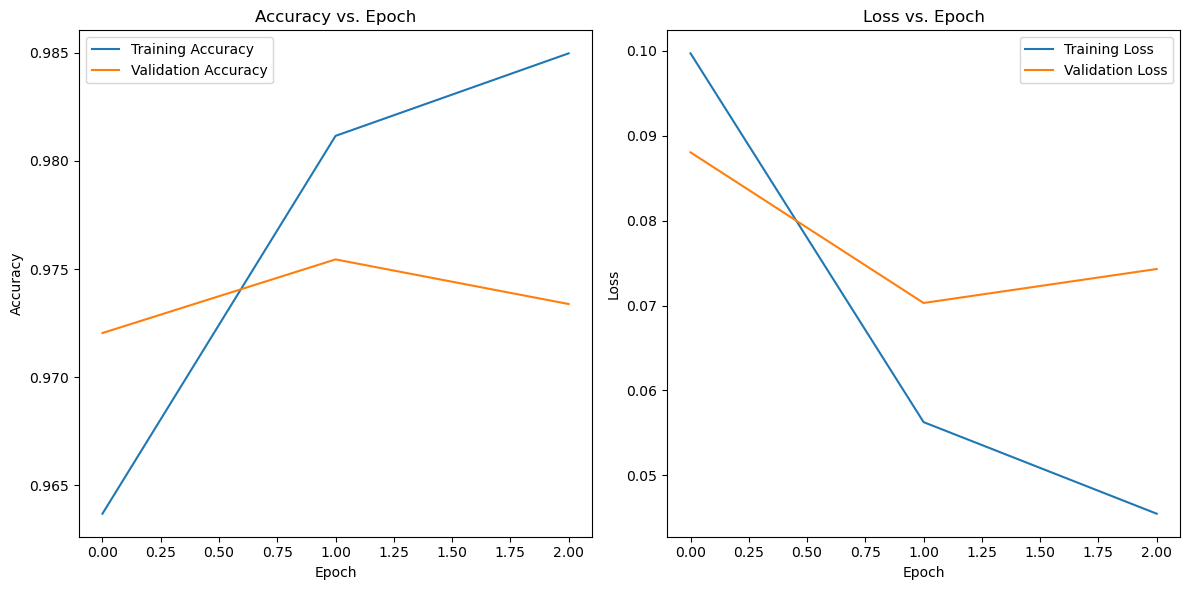

In [25]:
# Line plot for accuracy and loss on training and validation data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Evaluate the model
loss, accuracy = hybrid_transformerxl_model.evaluate([test_input_ids, test_attention_mask], test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

606/606 ━━━━━━━━━━━━━━━━━━━━ 449s 741ms/step - accuracy: 0.9733 - loss: 0.0744
Test Loss: 0.06956054270267487
Test Accuracy: 0.9747227430343628


In [27]:
# Generate classification report
from sklearn.metrics import classification_report

test_pred = hybrid_transformerxl_model.predict([test_input_ids, test_attention_mask])

/home/mhung/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_ids', 'attention_mask']. Received: the structure of inputs=('*', '*')
  warnings.warn(


606/606 ━━━━━━━━━━━━━━━━━━━━ 458s 755ms/step


In [28]:
# Generate classification report
from sklearn.metrics import classification_report

# Convert probabilities to binary predictions
test_pred_labels = (test_pred > 0.5).astype(int)

# Print classification report
print(classification_report(test_labels, test_pred_labels))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10182
           1       0.99      0.96      0.97      9203

    accuracy                           0.97     19385
   macro avg       0.98      0.97      0.97     19385
weighted avg       0.97      0.97      0.97     19385



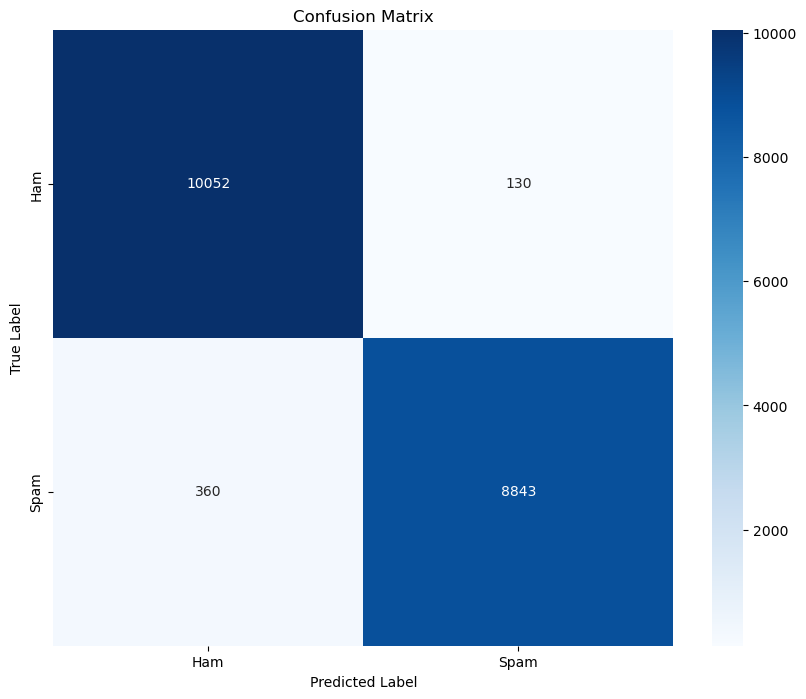

In [29]:
from sklearn.metrics import confusion_matrix
# Get the class labels
class_labels = ['Ham', 'Spam']

# Convert probabilities to binary predictions
test_pred_labels = (test_pred > 0.5).astype(int)

# Convert test_labels to single-label format
test_labels_single = test_labels.squeeze()

# Generate confusion matrix
cm = confusion_matrix(test_labels_single, test_pred_labels)

# Plot confusion matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

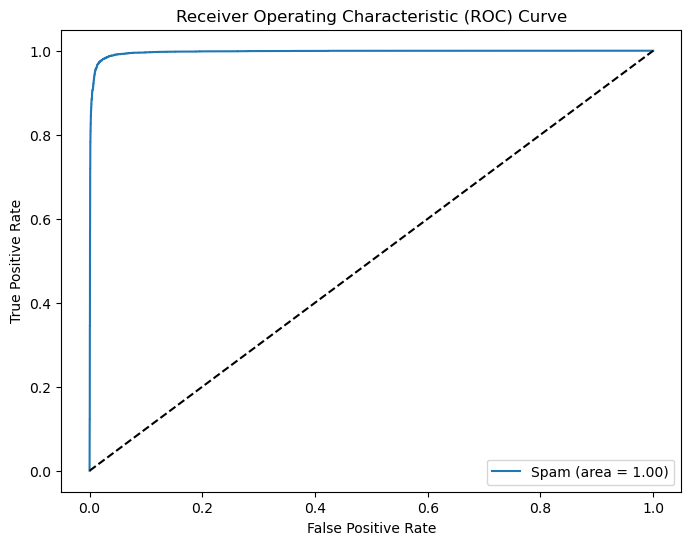

In [30]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Assuming binary classification, hence only one class
fpr, tpr, _ = roc_curve(test_labels, test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=class_labels[1] + ' (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [31]:
from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_pred_labels, average=None)

# Print precision, recall, and F1 score for each class
for i in range(len(class_labels)):
    print(f"Class: {class_labels[i]}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()

Class: Ham
Precision: 0.9654245101805609
Recall: 0.9872323708505205
F1 Score: 0.9762066621346023

Class: Spam
Precision: 0.9855120918310487
Recall: 0.9608823209822884
F1 Score: 0.9730413732394366



In [32]:
from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and F1 score averaged across all classes
precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(test_labels, test_pred_labels, average='weighted')

# Print average precision, recall, and F1 score
print("Average Precision:", precision_avg)
print("Average Recall:", recall_avg)
print("Average F1 Score:", f1_score_avg)

Average Precision: 0.9749610597771272
Average Recall: 0.9747227237554811
Average F1 Score: 0.9747039459260798
